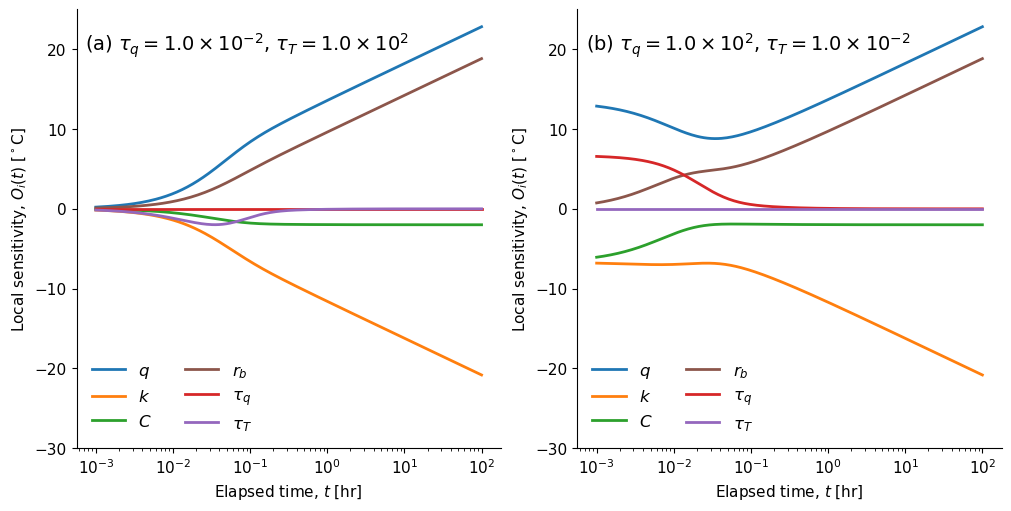

In [6]:
# ====================== Local sensitivity (time domain) — dual-lag TRT ======================
# (a) (b) 標題依照 tau_q, tau_T；全圖黑色外框；Early/Mid/Late 對齊 10^-1, 10^0, 10^1, 10^2

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.special import kv as besselk

plt.rcParams.update({
    "font.size": 11,
    "text.usetex": False,          # 若電腦沒裝 LaTeX，False 比較穩；標籤仍用 TeX 語法
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---------- Stehfest inversion ----------
def stehfest_inversion(t, func, args, N=8):
    ln2 = np.log(2.0)
    def V(k):
        v = 0.0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * (-1)**(k + N//2)
    return ln2/t * sum(V(k) * func(k*ln2/t, *args) for k in range(1, N+1))

# ---------- Dual-lag Laplace-domain solution ----------
#  T̄ = [ -q (1+s τ_q) / (k λ s (1+s τ_T)) ] * K0(λ r)/K1(λ r_b),  λ = sqrt( C s (1+s τ_q) / (k (1+s τ_T)) )
def T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam = np.sqrt((C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def _F_lag(s, r, tau_q, tau_T, q, k, C, r_b):
    return T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b)

def T_lag(r, t, tau_q, tau_T, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_lag, (r, tau_q, tau_T, q, k, C, r_b), N=N)

def T_series(params, t_s, N=8):
    r, q, k, C, r_b = params['r'], params['q'], params['k'], params['C'], params['r_b']
    tau_q, tau_T = params['tau_q'], params['tau_T']
    return np.array([T_lag(r, ti, tau_q, tau_T, q, k, C, r_b, N=N) for ti in t_s])

# ---------- Local sensitivity（central difference, relative step δ） ----------
def local_sensitivity(params, t_s, rel_step=1e-3, Ninv=8, names=None):
    if names is None:
        names = ['q','k','C','r_b','tau_q','tau_T']

    T0 = T_series(params, t_s, N=Ninv)
    T_safe = np.where(np.abs(T0) < 1e-12, 1e-12, T0)

    O = {}
    base = {k: params[k] for k in params}

    for key in names:
        p0 = base[key]
        p_plus  = p0 * (1.0 + rel_step)
        p_minus = p0 * (1.0 - rel_step)
        if key in ('k','C','tau_q','tau_T','r_b'):
            p_plus  = max(p_plus,  1e-30)
            p_minus = max(p_minus, 1e-30)

        # +δ
        if key == 'r_b':
            params['r_b'] = p_plus
            params['r']   = p_plus
        else:
            params[key]   = p_plus
            params['r']   = base['r']
            params['r_b'] = base['r_b']
        T_plus = T_series(params, t_s, N=Ninv)

        # -δ
        if key == 'r_b':
            params['r_b'] = p_minus
            params['r']   = p_minus
        else:
            params[key]   = p_minus
            params['r']   = base['r']
            params['r_b'] = base['r_b']
        T_minus = T_series(params, t_s, N=Ninv)

        # 還原
        for k0 in base:
            params[k0] = base[k0]

        O[key] = (T_plus - T_minus) / (2.0 * rel_step)

    return T0, O

# ---------- 時間軸（hr / s） ----------
t_h = np.logspace(-3, 2, 220)       # 10^-3 ~ 10^2 hr
t_s = t_h * 3600.0

# ---------- 兩組參數：Baseline 與 Swap ----------
base_common = {
    'q'    : -50.0 * 3600.0**3,
    'k'    :  2.5  * 3600.0**3,
    'C'    :  2.0e6* 3600.0**2,
    'r_b'  :  0.2,
    'r'    :  0.2,
}

params_A = base_common | {'tau_q': 0.01, 'tau_T': 100}   # (a)
params_B = base_common | {'tau_q': 100, 'tau_T': 0.01}   # (b)

# ---------- 計算局部敏感度 ----------
_, O_A = local_sensitivity(params_A.copy(), t_s, rel_step=1e-3, Ninv=8)
_, O_B = local_sensitivity(params_B.copy(), t_s, rel_step=1e-3, Ninv=8)

# ---------- 顏色、LaTeX 標籤 ----------
colors = {
    'q':'#1f77b4',   'k':'#ff7f0e',  'C':'#2ca02c',
    'r_b':'#8c564b', 'tau_q':'#d62728','tau_T':'#9467bd'
}
names_map = {'q':r'$q$', 'k':r'$k$', 'C':r'$C$',
             'r_b':r'$r_b$', 'tau_q':r'$\tau_q$', 'tau_T':r'$\tau_T$'}

# ---------- 畫圖 ----------
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)


def plot_panel(ax, O, title_str):
    # 帶號的 O_i(t)
    for key in ['q','k','C','r_b','tau_q','tau_T']:
        ax.plot(t_h, O[key], color=colors[key], lw=2, label=names_map[key])
    ax.set_xscale('log')
    ax.set_xlabel(r'Elapsed time, $t$ [hr]')
    ax.set_ylabel(r'Local sensitivity, $O_i(t)$ [$^\circ$C]')
    ax.legend(ncol=2, loc='lower left', fontsize=12, frameon=False)
    ax.text(0.02, 0.95, title_str, transform=ax.transAxes, ha="left", va="top", fontsize=14)
    ax.set_ylim(-30, None)

# (a) 與 (b) 標題（LaTeX 參數）
title_a = r'(a) $\tau_q=1.0\times10^{-2}$, $\tau_T=1.0\times10^{2}$'
title_b = r'(b) $\tau_q=1.0\times10^{2}$, $\tau_T=1.0\times10^{-2}$'

plot_panel(axs[0], O_A, title_a)
plot_panel(axs[1], O_B, title_b)

plt.show()

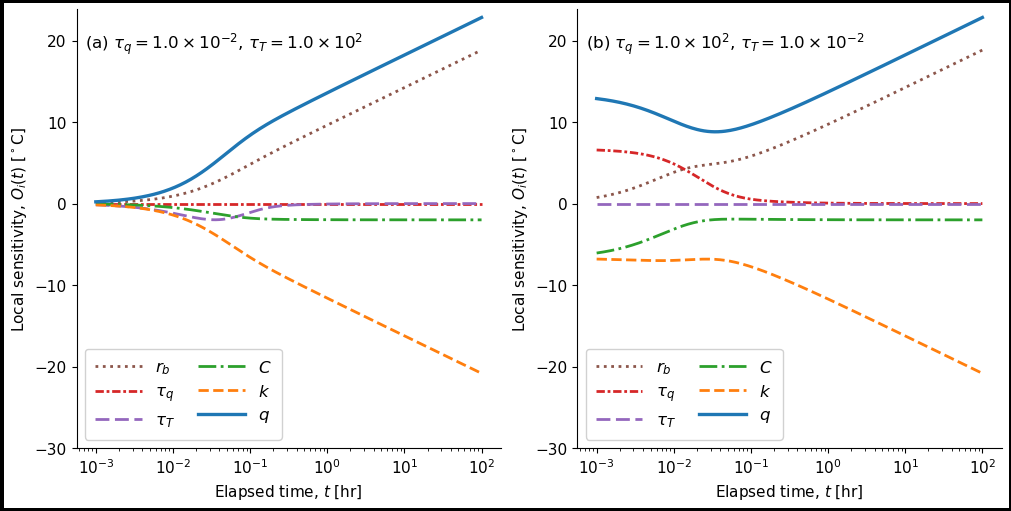

In [23]:
# ====================== Local sensitivity (time domain) — dual-lag TRT ======================
# (a) (b) 標題依照 tau_q, tau_T；全圖黑色外框；Early/Mid/Late 對齊 10^-1, 10^0, 10^1, 10^2

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.special import kv as besselk

plt.rcParams.update({
    "font.size": 11,
    "text.usetex": False,          # 若電腦沒裝 LaTeX，False 比較穩；標籤仍用 TeX 語法
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---------- Stehfest inversion ----------
def stehfest_inversion(t, func, args, N=8):
    ln2 = np.log(2.0)
    def V(k):
        v = 0.0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * (-1)**(k + N//2)
    return ln2/t * sum(V(k) * func(k*ln2/t, *args) for k in range(1, N+1))

# ---------- Dual-lag Laplace-domain solution ----------
#  T̄ = [ -q (1+s τ_q) / (k λ s (1+s τ_T)) ] * K0(λ r)/K1(λ r_b),  λ = sqrt( C s (1+s τ_q) / (k (1+s τ_T)) )
def T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam = np.sqrt((C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def _F_lag(s, r, tau_q, tau_T, q, k, C, r_b):
    return T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b)

def T_lag(r, t, tau_q, tau_T, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_lag, (r, tau_q, tau_T, q, k, C, r_b), N=N)

def T_series(params, t_s, N=8):
    r, q, k, C, r_b = params['r'], params['q'], params['k'], params['C'], params['r_b']
    tau_q, tau_T = params['tau_q'], params['tau_T']
    return np.array([T_lag(r, ti, tau_q, tau_T, q, k, C, r_b, N=N) for ti in t_s])

# ---------- Local sensitivity（central difference, relative step δ） ----------
def local_sensitivity(params, t_s, rel_step=1e-3, Ninv=8, names=None):
    if names is None:
        names = ['q','k','C','r_b','tau_q','tau_T']

    T0 = T_series(params, t_s, N=Ninv)
    T_safe = np.where(np.abs(T0) < 1e-12, 1e-12, T0)   # 目前沒用到，但保留

    O = {}
    base = {k: params[k] for k in params}

    for key in names:
        p0 = base[key]
        p_plus  = p0 * (1.0 + rel_step)
        p_minus = p0 * (1.0 - rel_step)
        if key in ('k','C','tau_q','tau_T','r_b'):
            p_plus  = max(p_plus,  1e-30)
            p_minus = max(p_minus, 1e-30)

        # +δ
        if key == 'r_b':
            params['r_b'] = p_plus
            params['r']   = p_plus
        else:
            params[key]   = p_plus
            params['r']   = base['r']
            params['r_b'] = base['r_b']
        T_plus = T_series(params, t_s, N=Ninv)

        # -δ
        if key == 'r_b':
            params['r_b'] = p_minus
            params['r']   = p_minus
        else:
            params[key]   = p_minus
            params['r']   = base['r']
            params['r_b'] = base['r_b']
        T_minus = T_series(params, t_s, N=Ninv)

        # 還原
        for k0 in base:
            params[k0] = base[k0]

        O[key] = (T_plus - T_minus) / (2.0 * rel_step)

    return T0, O

# ---------- 時間軸（hr / s） ----------
t_h = np.logspace(-3, 2, 220)       # 10^-3 ~ 10^2 hr
t_s = t_h * 3600.0

# ---------- 兩組參數：Baseline 與 Swap ----------
base_common = {
    'q'    : -50.0 * 3600.0**3,
    'k'    :  2.5  * 3600.0**3,
    'C'    :  2.0e6* 3600.0**2,
    'r_b'  :  0.2,
    'r'    :  0.2,
}
params_A = base_common | {'tau_q': 0.01, 'tau_T': 100}   # (a)
params_B = base_common | {'tau_q': 100,  'tau_T': 0.01}  # (b)

# ---------- 計算局部敏感度 ----------
_, O_A = local_sensitivity(params_A.copy(), t_s, rel_step=1e-3, Ninv=8)
_, O_B = local_sensitivity(params_B.copy(), t_s, rel_step=1e-3, Ninv=8)

# ---------- 顏色、線型、zorder、標籤 ----------
# 顏色：保留老師原色（你也可切換 batlow）
colors = {
    'q':'#1f77b4',   'k':'#ff7f0e',  'C':'#2ca02c',
    'r_b':'#8c564b', 'tau_q':'#d62728','tau_T':'#9467bd'
}
# 六條線給六種 *醒目* 線型（避免看起來都像破折）
linestyles = {
    'q':'-',                         # 實線
    'k':'--',                        # 長虛線
    'C':'-.',                        # 點畫線
    'r_b':':',                       # 點線
    'tau_q':(0,(3,1,1,1)),           # dash-dot-dot
    'tau_T':(0,(5,2))                # 自訂長短破折
}
# 繪圖順序與層級：把 q 放最後畫、zorder 最高，避免被蓋住
draw_order = ['r_b','tau_q','tau_T','C','k','q']
zorder_map = {'r_b':1, 'tau_q':1, 'tau_T':1, 'C':2, 'k':3, 'q':5}

names_map = {'q':r'$q$', 'k':r'$k$', 'C':r'$C$',
             'r_b':r'$r_b$', 'tau_q':r'$\tau_q$', 'tau_T':r'$\tau_T$'}

# ---------- 畫圖 ----------
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

def plot_panel(ax, O, title_str):
    for key in draw_order:
        ax.plot(t_h, O[key],
                color=colors[key],
                ls=linestyles[key],
                lw=2.4 if key=='q' else 2.0,    # q 稍微加粗
                zorder=zorder_map[key],
                label=names_map[key])
    ax.set_xscale('log')
    ax.set_xlabel(r'Elapsed time, $t$ [hr]')
    ax.set_ylabel(r'Local sensitivity, $O_i(t)$ [$^\circ$C]')
    ax.legend(ncol=2, loc='lower left', fontsize=12,
              frameon=True, facecolor='white', framealpha=0.9,
              handlelength=2.8, handletextpad=0.8, columnspacing=1.4, borderpad=0.6)
    ax.text(0.02, 0.95, title_str, transform=ax.transAxes, ha="left", va="top", fontsize=12)
    # 自動上下界 + 餘裕，讓線不貼邊
    ymin = min(np.min(O[k]) for k in O); ymax = max(np.max(O[k]) for k in O)
    ax.set_ylim(ymin-1, ymax+1)
    ax.set_ylim(-30,None)
# (a) 與 (b) 標題（LaTeX 參數）
title_a = r'(a) $\tau_q=1.0\times10^{-2}$, $\tau_T=1.0\times10^{2}$'
title_b = r'(b) $\tau_q=1.0\times10^{2}$, $\tau_T=1.0\times10^{-2}$'

plot_panel(axs[0], O_A, title_a)
plot_panel(axs[1], O_B, title_b)

# 外框黑框（整張圖）
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(5.0)

plt.show()


In [ ]:

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from scipy.special import kv as besselk  # Modified Bessel Kν

# --- optional colormap: cmcrameri.batlow ---
try:
    import cmcrameri.cm as cmc      # pip install cmcrameri
    cmap = cmc.batlow
except Exception:
    cmap = plt.get_cmap('viridis')

plt.rcParams.update({
    "font.size": 11,
    "text.usetex": False,      # 不要求系統 LaTeX；數學式用 mathtext
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---------- Stehfest 數值逆拉 (N 必須偶數) ----------
def stehfest_inversion(t, func, args, N=8):
    ln2 = np.log(2.0)
    def V(k):
        v = 0.0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * (-1)**(k + N//2)
    t = float(t)
    return ln2/t * sum(V(k) * func(k*ln2/t, *args) for k in range(1, N+1))

# ---------- 拉氏域解（Dual-lag / Fourier）----------
# T̄ = [ -q (1+s τ_q) / (k λ s (1+s τ_T)) ] * K0(λ r)/K1(λ r_b)
# λ  = sqrt( C s (1+s τ_q) / (k (1+s τ_T)) )
def T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam = np.sqrt((C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def T_bar_fourier(r, s, q, k, C, r_b):
    lam = np.sqrt(C*s/k)
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q / (k * lam * s)) * (K0 / K1)

def _F_lag(s, r, tau_q, tau_T, q, k, C, r_b):  return T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b)
def _F_fourier(s, r, q, k, C, r_b):           return T_bar_fourier(r, s, q, k, C, r_b)

# 時間域解（t, τ 以秒輸入；輸出為 ΔT [°C]）
def T_lag(r, t, tau_q, tau_T, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_lag,     (r, tau_q, tau_T, q, k, C, r_b), N=N)
def T_fourier(r, t, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_fourier, (r, q, k, C, r_b), N=N)

# ---------- 物理參數（與你先前設定一致） ----------
r, r_b = 0.2, 0.2
q = -50.0 * 3600.0**3             # W/m
k =   2.5 * 3600.0**3             # W/m/K
C = 2.0e6 * 3600.0**2             # J/m³/K

# 時間（有因次，hr），畫 0.1 ~ 120 小時
t_h = np.logspace(-3, 2.08, 190)  # 0.1 ~ ≈120 hr
t_s = t_h * 3600.0

# ---------- 作圖公用：算溫度序列 ----------
def T_series_lag_hours(tau_q_h, tau_T_h, Ninv=8):
    tq = tau_q_h * 3600.0
    tT = tau_T_h * 3600.0
    return np.array([T_lag(r, ti, tq, tT, q, k, C, r_b, N=Ninv) for ti in t_s])

def T_series_ils():
    return np.array([T_fourier(r, ti, q, k, C, r_b, N=8) for ti in t_s])

# ---------- Panel (a): 固定 tau_q=30h，掃 tau_T=20/40/50h ----------
tau_q_fixed_a = 1.0
tau_T_list_a  = [1.0, 5.0, 10.0, 15, 20]
linestyles = ['-', '--', ':', '-.']  # 對應三個變動值

# ---------- Panel (b): 固定 tau_T=30h，掃 tau_q=20/40/50h ----------
tau_T_fixed_b = 1.0
tau_q_list_b  = [1.0, 5.0, 10.0, 15, 20]

# 固定參數顏色（兩張圖各一色，出自 batlow 漸層）
color_a = cmap(0.65)    # (a) 用一個色
color_b = cmap(0.30)    # (b) 用另一個色



In [1]:
# ====================== Dual-lag TRT — dimensional (hours, °C) ======================
# (a) 固定 tau_q=30 h，掃 tau_T ∈ {20, 40, 50} h（線型）
# (b) 固定 tau_T=30 h，掃 tau_q ∈ {20, 40, 50} h（線型）
# 兩圖皆加入 ILS（τ=0）黑色基準線；顏色使用 cmcrameri.batlow（若無則退回 viridis）
# 圖例置於圖內；整張圖黑色外框；標題含 (a)(b) 與參數設定

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from scipy.special import kv as besselk  # Modified Bessel Kν

# --- optional colormap: cmcrameri.batlow ---
try:
    import cmcrameri.cm as cmc      # pip install cmcrameri
    cmap = cmc.batlow
except Exception:
    cmap = plt.get_cmap('viridis')

plt.rcParams.update({
    "font.size": 11,
    "text.usetex": False,      # 不要求系統 LaTeX；數學式用 mathtext
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---------- Stehfest 數值逆拉 (N 必須偶數) ----------
def stehfest_inversion(t, func, args, N=8):
    ln2 = np.log(2.0)
    def V(k):
        v = 0.0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * (-1)**(k + N//2)
    t = float(t)
    return ln2/t * sum(V(k) * func(k*ln2/t, *args) for k in range(1, N+1))

# ---------- 拉氏域解（Dual-lag / Fourier）----------
# T̄ = [ -q (1+s τ_q) / (k λ s (1+s τ_T)) ] * K0(λ r)/K1(λ r_b)
# λ  = sqrt( C s (1+s τ_q) / (k (1+s τ_T)) )
def T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam = np.sqrt((C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def T_bar_fourier(r, s, q, k, C, r_b):
    lam = np.sqrt(C*s/k)
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q / (k * lam * s)) * (K0 / K1)

def _F_lag(s, r, tau_q, tau_T, q, k, C, r_b):  return T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b)
def _F_fourier(s, r, q, k, C, r_b):           return T_bar_fourier(r, s, q, k, C, r_b)

# 時間域解（t, τ 以秒輸入；輸出為 ΔT [°C]）
def T_lag(r, t, tau_q, tau_T, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_lag,     (r, tau_q, tau_T, q, k, C, r_b), N=N)
def T_fourier(r, t, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_fourier, (r, q, k, C, r_b), N=N)

# ---------- 物理參數（與你先前設定一致） ----------
r, r_b = 0.2, 0.2
q = -50.0 * 3600.0**3             # W/m
k =   2.5 * 3600.0**3             # W/m/K
C = 2.0e6 * 3600.0**2             # J/m³/K

# 時間（有因次，hr），畫 0.1 ~ 120 小時
t_h = np.logspace(-3, 2.08, 190)  # 0.1 ~ ≈120 hr
t_s = t_h * 3600.0

# ---------- 作圖公用：算溫度序列 ----------
def T_series_lag_hours(tau_q_h, tau_T_h, Ninv=8):
    tq = tau_q_h * 3600.0
    tT = tau_T_h * 3600.0
    return np.array([T_lag(r, ti, tq, tT, q, k, C, r_b, N=Ninv) for ti in t_s])

def T_series_ils():
    return np.array([T_fourier(r, ti, q, k, C, r_b, N=8) for ti in t_s])

# ---------- Panel (a): 固定 tau_q=30h，掃 tau_T=20/40/50h ----------
tau_q_fixed_a = 1.0
tau_T_list_a  = [1.0, 5.0, 10.0, 15, 20]
linestyles = ['-', '--', ':', '-.']  # 對應三個變動值

# ---------- Panel (b): 固定 tau_T=30h，掃 tau_q=20/40/50h ----------
tau_T_fixed_b = 1.0
tau_q_list_b  = [1.0, 5.0, 10.0, 15, 20]

# 固定參數顏色（兩張圖各一色，出自 batlow 漸層）
color_a = cmap(0.65)    # (a) 用一個色
color_b = cmap(0.30)    # (b) 用另一個色




<>:15: SyntaxWarning: invalid escape sequence '\ '
<>:33: SyntaxWarning: invalid escape sequence '\ '
<>:15: SyntaxWarning: invalid escape sequence '\ '
<>:33: SyntaxWarning: invalid escape sequence '\ '
C:\Users\LIN\AppData\Local\Temp\ipykernel_14208\4282891564.py:15: SyntaxWarning: invalid escape sequence '\ '
  ax.text(0.02, 0.95, "(a) $\\tau_q=1\ \mathrm{h}$", transform=ax.transAxes, ha="left", va="top", fontsize=16)
C:\Users\LIN\AppData\Local\Temp\ipykernel_14208\4282891564.py:33: SyntaxWarning: invalid escape sequence '\ '
  ax.text(0.02, 0.95, "(b) $\\tau_T=1\ \mathrm{h}$", transform=ax.transAxes, ha="left", va="top", fontsize=16)


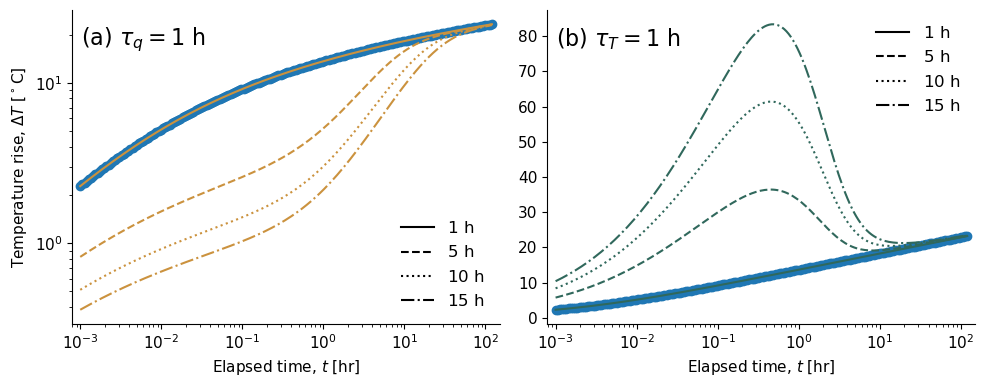

In [2]:
# ---------- 畫圖 ----------
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

def plot_panel_a(ax):
    # ILS baseline
    ax.plot(t_h, T_series_ils(), 'o', label='ILS')
    # 固定 tau_q 顏色；不同 tau_T 用線型
    for ls, tau_T_h in zip(linestyles, tau_T_list_a):
        Tvals = T_series_lag_hours(tau_q_fixed_a, tau_T_h)
        ax.plot(t_h, Tvals, color=color_a, ls=ls, lw=1.5)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'Elapsed time, $t$ [hr]')
    ax.set_ylabel(r'Temperature rise, $\Delta T$ [$^\circ$C]')
    ax.text(0.02, 0.95, "(a) $\\tau_q=1\ \mathrm{h}$", transform=ax.transAxes, ha="left", va="top", fontsize=16)
    # 內嵌圖例（顏色→固定，線型→變動）
    color_handles = [Line2D([0],[0], color=color_a, lw=1.5)]

    style_handles = [Line2D([0],[0], color='k', lw=1.5, ls=ls) for ls in linestyles]
    style_labels  = [r'$1\ \mathrm{h}$', r'$5\ \mathrm{h}$', r'$10\ \mathrm{h}$', r'$15\ \mathrm{h}$']
    ax.legend(style_handles, style_labels,
              loc='lower right', 
              frameon=False, fontsize=12)
def plot_panel_b(ax):
    ax.plot(t_h, T_series_ils(), 'o', label='ILS')
    for ls, tau_q_h in zip(linestyles, tau_q_list_b):
        Tvals = T_series_lag_hours(tau_q_h, tau_T_fixed_b)
        ax.plot(t_h, Tvals, color=color_b, ls=ls, lw=1.5)

    ax.set_xscale('log')
    ax.set_xlabel(r'Elapsed time, $t$ [hr]')

    ax.text(0.02, 0.95, "(b) $\\tau_T=1\ \mathrm{h}$", transform=ax.transAxes, ha="left", va="top", fontsize=16)

    color_handles = [Line2D([0],[0], color=color_b, lw=1.5)]

    style_handles = [Line2D([0],[0], color='k', lw=1.5, ls=ls) for ls in linestyles]
    style_labels  = [r'$1\ \mathrm{h}$', r'$5\ \mathrm{h}$', r'$10\ \mathrm{h}$', r'$15\ \mathrm{h}$']
    ax.legend(style_handles, style_labels,
              loc='upper right', 
              frameon=False, fontsize=12)

plot_panel_a(axes[0])
plot_panel_b(axes[1])

# 微調網格與留白
for ax in axes:    # 讓曲線更貼近邊界（避免多餘留白）
    ax.margins(x=0.02)

plt.tight_layout()
plt.show()


[INFO] start TRF...
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 3.6585e+01, final cost 2.6447e+01, first-order optimality 9.88e-04.
[INFO] TRF done in 0.26 s


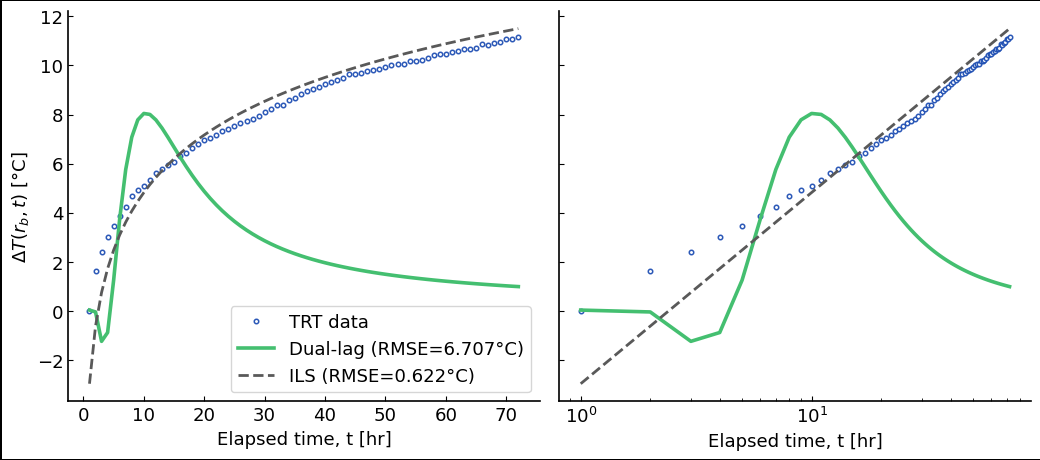


Estimated parameters (q fixed)
    Model  k (W/m·K)  C (J/m³·K)  τq (h)  τT (h)  q fixed (W/m)  RMSE (°C)
 Dual-lag     2.4809       5e+06  1.2575  2.9601            -70     6.7071
ILS(seed)     1.6471       8e+05     NaN     NaN            -70    0.62235


In [1]:
# ================== TRT parameter estimation (Dual-lag; q fixed; t in hr) ==================
# 只估 k, C, tau_q[h], tau_T[h]，q 固定；先 ILS 起點 → TRF（trust-region reflective）微調
# Excel 檔：Field data.xlsx，欄位：Time [hr], Temperature [°C]

import numpy as np, pandas as pd, math, matplotlib.pyplot as plt, time
from pathlib import Path
from scipy.special import kv as besselk
from scipy.optimize import least_squares

# ------------------------- 使用者設定 -------------------------
FILE      = "Field data.xlsx"     # Excel 檔名
COL_TIME  = "Time"                # 時間欄 (hr)
COL_TEMP  = "Temperature"         # 溫度欄 (°C)

Q_W_PER_M = -70.0                 # 固定 q [W/m]；加熱→負號（若與斜率不符，程式會自動翻轉一次）
R_BORE    = 0.2                   # 井半徑 [m]
R_EVAL    = R_BORE                # 評估半徑 r [m]

# —— 加速旋鈕（需要更快就往小改）——
N_STEHFEST = 6                    # Stehfest 階數：6 (快且穩)；4 (更快)；8 (較慢)
FIT_POINTS = 60                   # 擬合用的對數下採樣點數（畫圖仍用全資料）
FIT_RANGE  = None                 # 例：(0.2, 60) 只擬合 0.2–60 hr；None 表全域
MAX_NFEV   = 800                  # 最多函數評估次數（可調 300–800）

# ---------------------- 讀檔與資料前處理 ----------------------
df = pd.read_excel(FILE, engine="openpyxl")
assert {COL_TIME, COL_TEMP}.issubset(df.columns), "Excel 需含欄位 Time, Temperature"
t_hr  = df[COL_TIME].astype(float).to_numpy()
Tobs  = df[COL_TEMP].astype(float).to_numpy()
ordr  = np.argsort(t_hr); t_hr, Tobs = t_hr[ordr], Tobs[ordr]
dTobs = Tobs - Tobs[0]

# 若 Excel 內有 q 欄可覆寫（可省下手動輸入）
for key in ["q","Q","q_Wm","Q_Wm"]:
    if key in df.columns:
        Q_W_PER_M = float(df[key].iloc[0]); break

# 可選擇擬合視窗（通常 0.2–60 hr 會更穩）
if FIT_RANGE is not None:
    tmin, tmax = FIT_RANGE
    sel = (t_hr >= tmin) & (t_hr <= tmax)
    t_fit_full, y_fit_full = t_hr[sel], dTobs[sel]
else:
    t_fit_full, y_fit_full = t_hr, dTobs

# ---------------------- ILS 快估（閉式解） ----------------------
gamma = 0.5772156649
mask_late = t_hr >= np.percentile(t_hr, 70)                 # 取後 30% 當晚期
A, B = np.polyfit(np.log(t_hr[mask_late]), dTobs[mask_late], 1)   # ΔT ≈ A ln t + B

# 自動修正 q 符號（避免走錯方向）
if (A > 0 and Q_W_PER_M > 0) or (A < 0 and Q_W_PER_M < 0):
    Q_W_PER_M = -Q_W_PER_M

# k0, C0 seed（時間用 hr；k in W/m/K；C in J/m^3/K）
k0 = - Q_W_PER_M / (4*np.pi*A)
C0 = (4*k0)/(R_BORE**2) * np.exp( - (4*np.pi*k0/Q_W_PER_M)*B + gamma )
k0 = float(np.clip(k0, 0.6, 4.0))
C0 = float(np.clip(C0, 0.8e6, 4.0e6))
tq0, tT0 = 0.2, 1.0   # 小時級合理起點

# ---------------------- Stehfest 反演（hr 量綱） ----------------------
LN2, N_STE = np.log(2.0), N_STEHFEST
def _stehfest_coeff(N=N_STE):
    V = np.empty(N)
    for k in range(1, N+1):
        v = 0.0
        for j in range((k+1)//2, min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        V[k-1] = v * (-1)**(k + N//2)
    return V
VSTE = _stehfest_coeff()

def _stehfest_inv_hr(t, F, args):
    s = (np.arange(1, N_STE+1)*LN2)/t     # s 單位：1/hr
    vals = np.array([F(si, *args) for si in s])
    return (LN2/t) * np.dot(VSTE, vals)

# 拉氏域雙延遲：t, τ（hr）；k, q 轉為「每小時能量」以與 s 相容
def _Tbar_duallag_hr(r, s, tau_q_h, tau_T_h, q_Wm, k_WmK, C, r_b):
    H = 3600.0
    k_hr, q_hr = k_WmK*H, q_Wm*H
    lam = np.sqrt((C*s*(1.0 + s*tau_q_h))/(k_hr*(1.0 + s*tau_T_h)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0,K1])) or K1==0): return 0.0
    return (-q_hr*(1.0+s*tau_q_h)/(k_hr*lam*s*(1.0+s*tau_T_h))) * (K0/K1)

def series_duallag(t, k, C, tauq_h, tauT_h, q=Q_W_PER_M, r=R_EVAL, r_b=R_BORE):
    return np.array([_stehfest_inv_hr(tt, _Tbar_duallag_hr, (r, tauq_h, tauT_h, q, k, C, r_b))
                     for tt in t])

# ILS（hr）
def series_ils_hr(t, k, C, q=Q_W_PER_M, r_b=R_BORE):
    H = 3600.0
    k_hr, q_hr = k*H, q*H
    alpha_hr = k_hr / C
    return (-q_hr/(4*np.pi*k_hr))*(np.log(4*alpha_hr*t/r_b**2) - gamma)

# ---------------------- 下採樣 + 權重（加速且穩） ----------------------
target = np.geomspace(t_fit_full.min(), t_fit_full.max(), FIT_POINTS)
idx    = np.unique(np.clip(np.searchsorted(t_fit_full, target), 0, len(t_fit_full)-1))
t_fit, y_fit = t_fit_full[idx], y_fit_full[idx]

edges = np.geomspace(t_fit.min(), t_fit.max(), 16+1)   # 對數分箱，平衡早/晚期權重
binid = np.clip(np.searchsorted(edges, t_fit, side="right")-1, 0, len(edges)-2)
cnt   = np.maximum(1, np.bincount(binid, minlength=len(edges)-1)[binid])
w_fit = (1.0/cnt) / (1.0/cnt).mean()

# ---------------------- TRF 微調（一次就好） ----------------------
x0 = np.array([k0, C0, tq0, tT0])
lb = np.array([0.5, 0.8e6, 1e-3, 1e-3])
ub = np.array([5.0, 5.0e6, 20.0, 20.0])

def resid_dual(x):
    k, C, tauq_h, tauT_h = x
    return (series_duallag(t_fit, k, C, tauq_h, tauT_h) - y_fit) * np.sqrt(w_fit)

print("[INFO] start TRF...")
t0 = time.time()
sol = least_squares(resid_dual, x0=x0, bounds=(lb,ub),
                    method="trf", loss="soft_l1", f_scale=0.2,
                    x_scale=[1.0, 1e6, 1.0, 1.0], max_nfev=MAX_NFEV, verbose=1)
print("[INFO] TRF done in %.2f s" % (time.time()-t0))

kD, CD, tauqD, tauTD = sol.x

# 全資料預測與 RMSE
y_dual = series_duallag(t_hr, kD, CD, tauqD, tauTD)
rmseD  = float(np.sqrt(np.mean((y_dual - dTobs)**2)))
y_ils  = series_ils_hr(t_hr, k0, C0)
rmseI  = float(np.sqrt(np.mean((y_ils - dTobs)**2)))

# ------------------------------ 繪圖 ------------------------------
try:
    import cmcrameri as cmc; c_dual, c_ils = cmc.batlow(0.70), "0.35"
except Exception:
    from matplotlib import cm; c_dual, c_ils = cm.viridis(0.7), "0.35"

plt.rcParams.update({
    "font.size": 13, "axes.spines.top": False, "axes.spines.right": False,
    "axes.linewidth": 1.2, "xtick.direction": "in", "ytick.direction": "in",
})

fig, axs = plt.subplots(1,2, figsize=(10.6,4.8), sharey=True)

# ILS 畫空心圈圈（無連線）以和曲線清楚區分
ILS_STYLE = dict(ls="None", marker="o", ms=3.2, mfc="white", mec="#1f4fb3", mew=1.1, alpha=0.95)

# 左：線性
axs[0].plot(t_hr, dTobs, **ILS_STYLE, label="TRT data")
axs[0].plot(t_hr, y_dual, lw=2.6, color=c_dual, label=f"Dual-lag (RMSE={rmseD:.3f}°C)")
axs[0].plot(t_hr, y_ils,  lw=2.0, ls="--", color=c_ils, label=f"ILS (RMSE={rmseI:.3f}°C)")
axs[0].set_xlabel("Elapsed time, t [hr]"); axs[0].set_ylabel(r"$\Delta T(r_b,t)$ [°C]")
axs[0].legend(loc="lower right", frameon=True)

# 右：半對數 x
axs[1].plot(t_hr, dTobs, **ILS_STYLE)
axs[1].plot(t_hr, y_dual, lw=2.6, color=c_dual)
axs[1].plot(t_hr, y_ils,  lw=2.0, ls="--", color=c_ils)
axs[1].set_xscale("log"); axs[1].set_xlabel("Elapsed time, t [hr]")

# 黑外框
for ax in axs:
    for sp in ax.spines.values(): sp.set_edgecolor("black"); sp.set_linewidth(1.2)
fig.patch.set_edgecolor("black"); fig.patch.set_linewidth(2.0)

plt.tight_layout(); plt.show()

# --------------------------- 列印參數表 ---------------------------
tbl = pd.DataFrame([
    ["Dual-lag", kD, CD, tauqD, tauTD, Q_W_PER_M, rmseD],
    ["ILS(seed)", k0, C0, np.nan, np.nan, Q_W_PER_M, rmseI],
], columns=["Model","k (W/m·K)","C (J/m³·K)","τq (h)","τT (h)","q fixed (W/m)","RMSE (°C)"])
pd.options.display.float_format = "{:,.5g}".format
print("\nEstimated parameters (q fixed)\n" + tbl.to_string(index=False))


[INFO] 進行 DE 全域搜尋 …
[INFO] TRF 局部精修 …

Estimated parameters (q 固定為 50.000 W/m)
k      = 1.1720 W/mK
C      = 2.412e+06 J/m^3K
tau_q  = 0.0010 h
tau_T  = 7.9216 h
RMSE   = dual-lag: 0.247 °C,  ILS: 0.474 °C


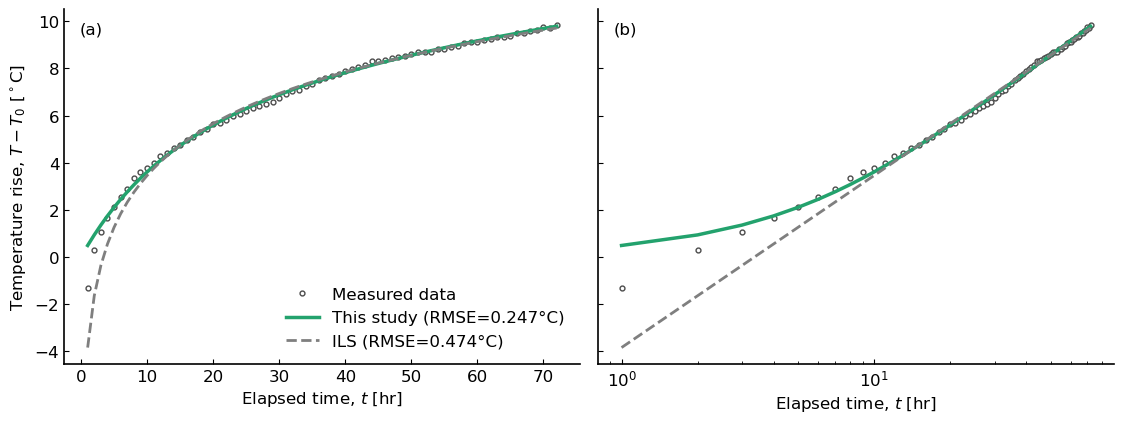

In [14]:
# ===============================================================
#  Dual-lag TRT 參數推估（DE + TRF）與 ILS 基準、兩面板圖、RMSE
#  內部一律使用 SI 單位（秒、W/m、W/mK、J/m³K），畫圖軸顯示 hr
# ===============================================================

import numpy as np
import pandas as pd
import math
import warnings
from scipy.special import kv as besselk
from scipy.optimize import differential_evolution, least_squares
import matplotlib.pyplot as plt

# ---------- 圖形風格 ----------
plt.rcParams.update({
    "font.size": 12,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---------- 1) 讀資料（Time[hr], Temperature[°C]）→ t_s, ΔT ----------
DATA_PATH = "Field data.xlsx"   # ← 你的 Excel 檔名
TIME_COL  = "Time"
TEMP_COL  = "Temperature"
N_BASE    = 3                   # 以最初 N 筆平均當 T0（可調整）

df = pd.read_excel(DATA_PATH)
t_hr  = df[TIME_COL].to_numpy(dtype=float)
T_obs = df[TEMP_COL].to_numpy(dtype=float)

T0     = float(np.mean(T_obs[:N_BASE]))
dT_obs = T_obs - T0

# 內部用秒
t_s = t_hr * 3600.0

# ---------- 2) 幾何與負載（SI） ----------
r_b   = 0.2          # [m]
r_eval= r_b
q_lin = 50.0         # [W/m] 加熱為正值（請確認現場實際輸入熱流）
assert 0 < q_lin < 5e3, "q_lin 看起來不合理，請檢查單位/數值！"

# ---------- 3) Stehfest 反拉氏 ----------
def stehfest_inversion(t, F_of_s, args, N=10):
    if t <= 0:
        return 0.0
    ln2 = math.log(2.0)
    def V(k):
        v = 0.0
        for j in range((k+1)//2, min(k, N//2)+1):
            num = (j**(N//2)) * math.factorial(2*j)
            den = (math.factorial(N//2 - j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * ((-1)**(k + N//2))
    total = 0.0
    for k in range(1, N+1):
        s_k = k * ln2 / t
        total += V(k) * F_of_s(s_k, *args)
    return ln2/t * total

# ---------- 4) Dual-lag 拉氏域解（採 q>0；公式不加負號 → ΔT>0） ----------
def Tbar_duallag(r, s, tau_q, tau_T, q, k, C, r_b):
    # lam = sqrt( C*s*(1+s*tau_q) / (k*(1+s*tau_T)) )
    lam2 = (C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T) + 1e-300)
    if lam2 <= 0 or not np.isfinite(lam2):
        return 0.0
    lam = math.sqrt(lam2)
    K0 = besselk(0, lam*r)
    K1 = besselk(1, lam*r_b)
    if not np.isfinite(K0) or not np.isfinite(K1) or abs(K1) < 1e-300:
        return 0.0
    # 注意：不加負號，q>0 表示加熱 → ΔT 為正
    return (q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def T_time_duallag(r, t, tau_q, tau_T, q, k, C, r_b, N=10):
    args = (r, tau_q, tau_T, q, k, C, r_b)
    return stehfest_inversion(t, lambda s, r, tau_q, tau_T, q, k, C, r_b:
                              Tbar_duallag(r, s, tau_q, tau_T, q, k, C, r_b), args, N=N)

# 一次算整串 ΔT（theta = [k, C, tau_q(h), tau_T(h)]）
def series_duallag(theta, t_s):
    k, C, tau_q_h, tau_T_h = theta
    tau_q = float(tau_q_h) * 3600.0
    tau_T = float(tau_T_h) * 3600.0
    ys = []
    for ti in t_s:
        ys.append(T_time_duallag(r_eval, float(ti), tau_q, tau_T, q_lin, k, C, r_b, N=10))
    return np.asarray(ys, float)

# ---------- 5) ILS（晚時 ln(t秒) 迴歸） ----------
def ils_series(t_s, dT_obs, t_min_hr=10.0):
    mask = (t_s >= t_min_hr*3600.0)
    x = np.log(t_s[mask])
    y = dT_obs[mask]
    A = np.vstack([np.ones_like(x), x]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]      # ΔT ≈ a + b ln(t_s)
    yhat = a + b*np.log(t_s)
    return yhat, (float(a), float(b))

# ---------- 6) RMSE 與形狀懲罰（避免初期向下掉） ----------
def RMSE(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def gentle_shape_penalty(t_s, lam_monotone=5e2, lam_late=1e2):
    # 讓曲線大致單調不降；末段斜率 > 0（很溫和）
    t_s = np.asarray(t_s, float)
    n = len(t_s)
    tail0 = max(2, int(0.95*n))
    def _pen(theta_phys, y):
        y  = np.asarray(y, float)
        dy = np.diff(y)
        pen = 0.0
        pen += lam_monotone * np.sum(np.clip(-dy, 0, None))
        late_slope = (y[-1] - y[tail0]) / (t_s[-1] - t_s[tail0] + 1e-12)
        pen += lam_late * np.clip(1e-9 - late_slope, 0, None)
        return pen
    return _pen

# ---------- 7) 參數化：tau_T = tau_q + δ（δ≥0） ----------
USE_REPARAM = True

def theta_raw_to_phys(theta_raw):
    if not USE_REPARAM:
        return np.asarray(theta_raw, float)
    k, C, tau_q_h, delta_h = theta_raw
    tau_T_h = tau_q_h + max(0.0, delta_h)
    return np.array([k, C, tau_q_h, tau_T_h], float)

def model_from_theta_raw(theta_raw):
    return series_duallag(theta_raw_to_phys(theta_raw), t_s)

# ---------- 8) DE 全域搜尋 ----------
bounds_raw = [
    (0.6, 4.5),         # k [W/mK]
    (0.8e6, 4.5e6),     # C [J/m3K]
    (1e-3, 8.0),        # tau_q [hr]
    (0.0, 80.0) if USE_REPARAM else (1e-3, 80.0)  # delta[h] 或 tau_T[h]
]

penalty_fun = gentle_shape_penalty(t_s, lam_monotone=5e2, lam_late=1e2)

def obj_DE(theta_raw):
    yhat = model_from_theta_raw(theta_raw)
    sse  = np.sum((yhat - dT_obs)**2)
    sse += penalty_fun(theta_raw_to_phys(theta_raw), yhat)
    return sse

print("[INFO] 進行 DE 全域搜尋 …")
res_de = differential_evolution(
    obj_DE, bounds=bounds_raw, strategy="best1bin",
    popsize=18, maxiter=200, tol=1e-6, seed=42,
    polish=True, workers=1
)
theta_raw_best = res_de.x
theta_best     = theta_raw_to_phys(theta_raw_best)
y_dual         = series_duallag(theta_best, t_s)

# ---------- 9) TRF 局部精修（可關閉） ----------
USE_TRF = True
if USE_TRF:
    print("[INFO] TRF 局部精修 …")
    if USE_REPARAM:
        lb = np.array([b[0] for b in bounds_raw], float)
        ub = np.array([b[1] for b in bounds_raw], float)
        def fun_raw(th_raw):
            return series_duallag(theta_raw_to_phys(th_raw), t_s) - dT_obs
        res_ls = least_squares(fun_raw, theta_raw_best, bounds=(lb, ub),
                               method="trf", ftol=1e-8, xtol=1e-8)
        theta_best = theta_raw_to_phys(res_ls.x)
        y_dual     = series_duallag(theta_best, t_s)
    else:
        lb = np.array([b[0] for b in bounds_raw], float)
        ub = np.array([b[1] for b in bounds_raw], float)
        def fun_phys(th):
            return series_duallag(th, t_s) - dT_obs
        res_ls = least_squares(fun_phys, theta_best, bounds=(lb, ub),
                               method="trf", ftol=1e-8, xtol=1e-8)
        theta_best = res_ls.x
        y_dual     = series_duallag(theta_best, t_s)

# ---------- 10) ILS 基準 ----------
y_ils, (a_ils, b_ils) = ils_series(t_s, dT_obs, t_min_hr=10.0)

# ---------- 11) RMSE & 列印 ----------
def print_results(theta, y_dual, y_ils):
    rmse_dual = RMSE(dT_obs, y_dual)
    rmse_ils  = RMSE(dT_obs, y_ils)
    k_hat, C_hat, tauq_h, tauT_h = theta
    print("\nEstimated parameters (q 固定為 %.3f W/m)" % q_lin)
    print("k      = %.4f W/mK"     % k_hat)
    print("C      = %.3e J/m^3K"   % C_hat)
    print("tau_q  = %.4f h"        % tauq_h)
    print("tau_T  = %.4f h"        % tauT_h)
    print("RMSE   = dual-lag: %.3f °C,  ILS: %.3f °C" % (rmse_dual, rmse_ils))
    return rmse_dual, rmse_ils

rmse_dual, rmse_ils = print_results(theta_best, y_dual, y_ils)

# ---------- 12) 圖：左（linear），右（semi-log） ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.4, 4.4), sharey=True)

# (a) 線性
ax1.plot(t_hr, dT_obs, "o", ms=3.5, color="#4c4c4c", mfc="white", label="Measured data")
ax1.plot(t_hr, y_dual, color="#23a26d", lw=2.5, label=f"This study (RMSE={rmse_dual:.3f}°C)")
ax1.plot(t_hr, y_ils,  "--", color="#7f7f7f", lw=2.0, label=f"ILS (RMSE={rmse_ils:.3f}°C)")
ax1.set_xlabel(r"Elapsed time, $t$ [hr]")
ax1.set_ylabel(r"Temperature rise, $T-T_0$ [$^\circ$C]")
ax1.text(0.03, 0.93, "(a)", transform=ax1.transAxes)
ax1.legend(loc="lower right", frameon=False)

# (b) 半對數
ax2.semilogx(t_hr, dT_obs, "o", ms=3.5, color="#4c4c4c", mfc="white")
ax2.semilogx(t_hr, y_dual, color="#23a26d", lw=2.5)
ax2.semilogx(t_hr, y_ils,  "--", color="#7f7f7f", lw=2.0)
ax2.set_xlabel(r"Elapsed time, $t$ [hr]")
ax2.text(0.03, 0.93, "(b)", transform=ax2.transAxes)

plt.tight_layout()
plt.show()

# ---------- 13) （可選）輸出圖與序列 ----------
SAVE_FIG  = False
SAVE_XLSX = False

if SAVE_FIG:
    fig.savefig("fig_duallag_vs_ils.png", dpi=300, bbox_inches="tight")
if SAVE_XLSX:
    out = pd.DataFrame({
        "t_hr": t_hr, "dT_obs": dT_obs,
        "dual_lag": y_dual, "ILS": y_ils
    })
    out.to_excel("fit_series.xlsx", index=False)


[INFO] 進行 DE 全域搜尋 …
[INFO] TRF 局部精修 …

Estimated parameters (q 固定為 50.000 W/m)
k      = 1.1720 W/mK
C      = 2.412e+06 J/m^3K
tau_q  = 0.0010 h
tau_T  = 7.9216 h
RMSE   = dual-lag: 0.247 °C,  ILS: 0.195 °C
ILS fitted: k = 1.1597 W/mK,  C = 1.016e+06 J/m^3K


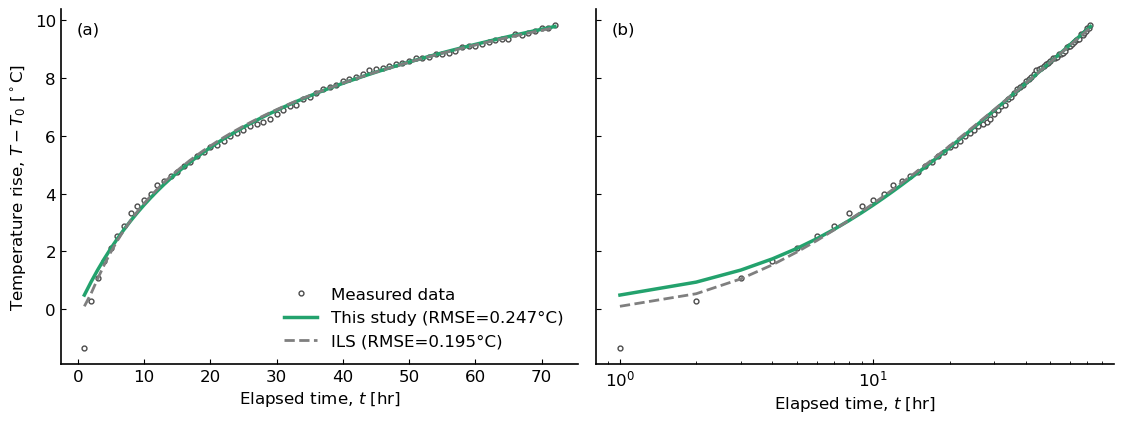


=== Summary: k, C, τq, τT, RMSE ===
             Solution k (W/m·K) C (MJ/m³·K) τq (h) τT (h) RMSE (°C)
This study (dual-lag)      1.17        2.41  0.001  7.922     0.247
                  ILS      1.16        1.02    NaN    NaN     0.195


In [18]:
# ===============================================================
#  Dual-lag TRT 參數推估（DE + TRF）與 ILS 基準、兩面板圖、RMSE
#  + 論文 Table 2 風格 Summary（Console + Excel + PNG）
#  內部一律使用 SI 單位（秒、W/m、W/mK、J/m³K），畫圖軸顯示 hr
# ===============================================================

import numpy as np
import pandas as pd
import math
import warnings
from scipy.special import kv as besselk
from scipy.optimize import differential_evolution, least_squares
import matplotlib.pyplot as plt

# ---------- 圖形風格 ----------
plt.rcParams.update({
    "font.size": 12,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ========== 可調參數 ==========
DATA_PATH = "Field data.xlsx"   # ← 你的 Excel 檔名
TIME_COL  = "Time"
TEMP_COL  = "Temperature"
N_BASE    = 3                   # 以最初 N 筆平均當 T0（可調整）
r_b   = 0.2                     # [m] 井徑
r_eval= r_b
q_lin = 50.0                    # [W/m]（正值=加熱；請確認現場輸入）
assert 0 < q_lin < 5e3, "q_lin 看起來不合理，請檢查單位/數值！"

SAVE_FIG       = True
SAVE_XLSX      = True
SAVE_TABLE_PNG = True

# ---------- 1) 讀資料（Time[hr], Temperature[°C]）→ t_s, ΔT ----------
df = pd.read_excel(DATA_PATH)
t_hr  = df[TIME_COL].to_numpy(dtype=float)
T_obs = df[TEMP_COL].to_numpy(dtype=float)
T0     = float(np.mean(T_obs[:N_BASE]))
dT_obs = T_obs - T0
t_s = t_hr * 3600.0   # 內部用秒

# ---------- 2) Stehfest 反拉氏 ----------
def stehfest_inversion(t, F_of_s, args, N=10):
    if t <= 0:
        return 0.0
    ln2 = math.log(2.0)
    def V(k):
        v = 0.0
        for j in range((k+1)//2, min(k, N//2)+1):
            num = (j**(N//2)) * math.factorial(2*j)
            den = (math.factorial(N//2 - j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * ((-1)**(k + N//2))
    total = 0.0
    for k in range(1, N+1):
        s_k = k * ln2 / t
        total += V(k) * F_of_s(s_k, *args)
    return ln2/t * total

# ---------- 3) Dual-lag 拉氏域解（q>0 → ΔT>0） ----------
def Tbar_duallag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam2 = (C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T) + 1e-300)
    if lam2 <= 0 or not np.isfinite(lam2):
        return 0.0
    lam = math.sqrt(lam2)
    K0 = besselk(0, lam*r)
    K1 = besselk(1, lam*r_b)
    if not np.isfinite(K0) or not np.isfinite(K1) or abs(K1) < 1e-300:
        return 0.0
    return (q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def T_time_duallag(r, t, tau_q, tau_T, q, k, C, r_b, N=10):
    args = (r, tau_q, tau_T, q, k, C, r_b)
    return stehfest_inversion(t, lambda s, r, tau_q, tau_T, q, k, C, r_b:
                              Tbar_duallag(r, s, tau_q, tau_T, q, k, C, r_b), args, N=N)

def series_duallag(theta, t_s):
    k, C, tau_q_h, tau_T_h = theta
    tau_q = float(tau_q_h) * 3600.0
    tau_T = float(tau_T_h) * 3600.0
    return np.array([T_time_duallag(r_eval, float(ti), tau_q, tau_T, q_lin, k, C, r_b, N=10)
                     for ti in t_s], float)

# ---------- 4) ILS（晚時 ln(t秒) 迴歸） ----------
def ils_series(t_s, dT_obs, t_min_hr=10.0):
    mask = (t_s >= t_min_hr*3600.0)
    x = np.log(t_s[mask])
    y = dT_obs[mask]
    A = np.vstack([np.ones_like(x), x]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]  # ΔT ≈ a + b ln(t_s)
    yhat = a + b*np.log(t_s)
    return yhat, (float(a), float(b))

# ---------- 5) RMSE 與形狀懲罰 ----------
def RMSE(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def gentle_shape_penalty(t_s, lam_monotone=5e2, lam_late=1e2):
    t_s = np.asarray(t_s, float)
    n = len(t_s)
    tail0 = max(2, int(0.95*n))
    def _pen(theta_phys, y):
        y  = np.asarray(y, float)
        dy = np.diff(y)
        pen = 0.0
        pen += lam_monotone * np.sum(np.clip(-dy, 0, None))
        late_slope = (y[-1] - y[tail0]) / (t_s[-1] - t_s[tail0] + 1e-12)
        pen += lam_late * np.clip(1e-9 - late_slope, 0, None)
        return pen
    return _pen

# ---------- 6) 參數化：tau_T = tau_q + δ（δ≥0） ----------
USE_REPARAM = True

def theta_raw_to_phys(theta_raw):
    if not USE_REPARAM:
        return np.asarray(theta_raw, float)
    k, C, tau_q_h, delta_h = theta_raw
    tau_T_h = tau_q_h + max(0.0, delta_h)
    return np.array([k, C, tau_q_h, tau_T_h], float)

def model_from_theta_raw(theta_raw):
    return series_duallag(theta_raw_to_phys(theta_raw), t_s)

# ---------- 7) DE 全域搜尋 ----------
bounds_raw = [
    (0.6, 4.5),         # k [W/mK]
    (0.8e6, 4.5e6),     # C [J/m3K]
    (1e-3, 8.0),        # tau_q [hr]
    (0.0, 80.0) if USE_REPARAM else (1e-3, 80.0)  # delta[h] 或 tau_T[h]
]
penalty_fun = gentle_shape_penalty(t_s, lam_monotone=5e2, lam_late=1e2)

def obj_DE(theta_raw):
    yhat = model_from_theta_raw(theta_raw)
    sse  = np.sum((yhat - dT_obs)**2)
    sse += penalty_fun(theta_raw_to_phys(theta_raw), yhat)
    return sse

print("[INFO] 進行 DE 全域搜尋 …")
res_de = differential_evolution(
    obj_DE, bounds=bounds_raw, strategy="best1bin",
    popsize=18, maxiter=200, tol=1e-6, seed=42,
    polish=True, workers=1
)
theta_raw_best = res_de.x
theta_best     = theta_raw_to_phys(theta_raw_best)
y_dual         = series_duallag(theta_best, t_s)

# ---------- 8) TRF 局部精修 ----------
print("[INFO] TRF 局部精修 …")
lb = np.array([b[0] for b in bounds_raw], float)
ub = np.array([b[1] for b in bounds_raw], float)

def fun_raw(th_raw):
    return series_duallag(theta_raw_to_phys(th_raw), t_s) - dT_obs

res_ls = least_squares(fun_raw, theta_raw_best, bounds=(lb, ub),
                       method="trf", ftol=1e-8, xtol=1e-8)
theta_best = theta_raw_to_phys(res_ls.x)
y_dual     = series_duallag(theta_best, t_s)

# ---------- 10) ILS（完整瞬態解：同時估 k 與 C） ----------
from scipy.special import exp1  # E1(x)

def ils_full_series_given(k, C, t_s):
    # α = k/C；避免 0 除
    alpha = k / (C + 1e-300)
    z = (r_b**2) / (4.0*alpha*np.maximum(t_s, 1e-12))
    return (q_lin/(4.0*np.pi*k)) * exp1(z)  # ΔT(t)

def fit_ils_full(t_s, dT_obs,
                 k_bounds=(0.6, 5.0), C_bounds=(0.8e6, 4.5e6),
                 k0=None, C0=None):
    # 初值：k 用前面 ILS slope 的結果（若有），C 給一個合理值
    if k0 is None:
        k0 = 1.5  # W/mK（給個中間值）
    if C0 is None:
        C0 = 2.0e6  # J/m^3K

    lb = np.array([k_bounds[0], C_bounds[0]], float)
    ub = np.array([k_bounds[1], C_bounds[1]], float)

    def resid(theta):
        k, C = theta
        return ils_full_series_given(k, C, t_s) - dT_obs

    res = least_squares(resid, x0=np.array([k0, C0]), bounds=(lb, ub), method="trf",
                        ftol=1e-8, xtol=1e-8)
    k_hat_ils, C_hat_ils = res.x
    y_ils = ils_full_series_given(k_hat_ils, C_hat_ils, t_s)
    return k_hat_ils, C_hat_ils, y_ils

# 執行 ILS 完整擬合
k_ils, C_ils, y_ils = fit_ils_full(t_s, dT_obs)

# ---------- 11) RMSE & 列印（更新用 ILS 完整解） ----------
rmse_dual = RMSE(dT_obs, y_dual)
rmse_ils  = RMSE(dT_obs, y_ils)

k_hat, C_hat, tauq_h, tauT_h = theta_best
print("\nEstimated parameters (q 固定為 %.3f W/m)" % q_lin)
print("k      = %.4f W/mK"     % k_hat)
print("C      = %.3e J/m^3K"   % C_hat)
print("tau_q  = %.4f h"        % tauq_h)
print("tau_T  = %.4f h"        % tauT_h)
print("RMSE   = dual-lag: %.3f °C,  ILS: %.3f °C" % (rmse_dual, rmse_ils))
print("ILS fitted: k = %.4f W/mK,  C = %.3e J/m^3K" % (k_ils, C_ils))

# ---------- 12) 圖（仍與原本一致，只是把 y_ils 換成完整解） ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.4, 4.4), sharey=True)

ax1.plot(t_hr, dT_obs, "o", ms=3.5, color="#4c4c4c", mfc="white", label="Measured data")
ax1.plot(t_hr, y_dual, color="#23a26d", lw=2.5, label=f"This study (RMSE={rmse_dual:.3f}°C)")
ax1.plot(t_hr, y_ils,  "--", color="#7f7f7f", lw=2.0, label=f"ILS (RMSE={rmse_ils:.3f}°C)")
ax1.set_xlabel(r"Elapsed time, $t$ [hr]")
ax1.set_ylabel(r"Temperature rise, $T-T_0$ [$^\circ$C]")
ax1.text(0.03, 0.93, "(a)", transform=ax1.transAxes)
ax1.legend(loc="lower right", frameon=False)

ax2.semilogx(t_hr, dT_obs, "o", ms=3.5, color="#4c4c4c", mfc="white")
ax2.semilogx(t_hr, y_dual, color="#23a26d", lw=2.5)
ax2.semilogx(t_hr, y_ils,  "--", color="#7f7f7f", lw=2.0)
ax2.set_xlabel(r"Elapsed time, $t$ [hr]")
ax2.text(0.03, 0.93, "(b)", transform=ax2.transAxes)

plt.tight_layout()
plt.show()

# ---------- 13) Summary 表（k, C, τq, τT, RMSE；ILS 也有 C） ----------
Cs_MJ     = C_hat / 1e6
C_ils_MJ  = C_ils / 1e6

summary_kctt = pd.DataFrame({
    "Solution":       ["This study (dual-lag)", "ILS"],
    "k (W/m·K)":      [k_hat, k_ils],
    "C (MJ/m³·K)":    [Cs_MJ, C_ils_MJ],  # ILS 現在也估 C
    "τq (h)":         [tauq_h, np.nan],   # ILS 無 τq
    "τT (h)":         [tauT_h, np.nan],   # ILS 無 τT
    "RMSE (°C)":      [rmse_dual, rmse_ils],
})

print("\n=== Summary: k, C, τq, τT, RMSE ===")
print(summary_kctt.to_string(index=False, formatters={
    "k (W/m·K)":    lambda v: f"{v:,.3g}",
    "C (MJ/m³·K)":  lambda v: f"{v:,.3g}",
    "τq (h)":       lambda v: f"{v:.3f}" if np.isfinite(v) else "—",
    "τT (h)":       lambda v: f"{v:.3f}" if np.isfinite(v) else "—",
    "RMSE (°C)":    lambda v: f"{v:.3f}",
}))


